In [43]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.dtypes

#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

date       datetime64[ns]
price             float64
wallets             int64
address           float64
mined             float64
dtype: object

In [44]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [45]:
df

,date,price,wallets,address,mined,Metcafe,value,networkvalue
0,2010-09-25,0.1,2,656.0,4109450.00,4.303360e+05,0.10,0.00
1,2010-09-26,0.1,2,444.0,4110750.00,1.971360e+05,0.05,0.05
2,2010-09-27,0.1,2,1070.0,4132150.00,1.144900e+06,0.28,-0.18
3,2010-09-28,0.1,2,1503.0,4133200.00,2.259009e+06,0.55,-0.45
4,2010-09-29,0.1,2,1049.0,4148050.00,1.100401e+06,0.27,-0.17
...,...,...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,8.550350e+11,44566.31,-25403.71
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,6.895708e+11,35940.19,-16735.39
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,6.466411e+11,33700.99,-14129.79
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,8.451934e+11,44046.74,-24715.24


In [46]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

00:57:37 - cmdstanpy - INFO - Chain [1] start processing
00:57:37 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,67579.622795,58146.842715,77467.556666
5112,2024-10-21,67786.517389,58142.479252,77813.520364
5113,2024-10-22,67956.169026,59102.478389,76994.753592
5114,2024-10-23,68193.892712,58536.229520,78106.694082
5115,2024-10-24,68339.782496,59641.292751,78602.645287


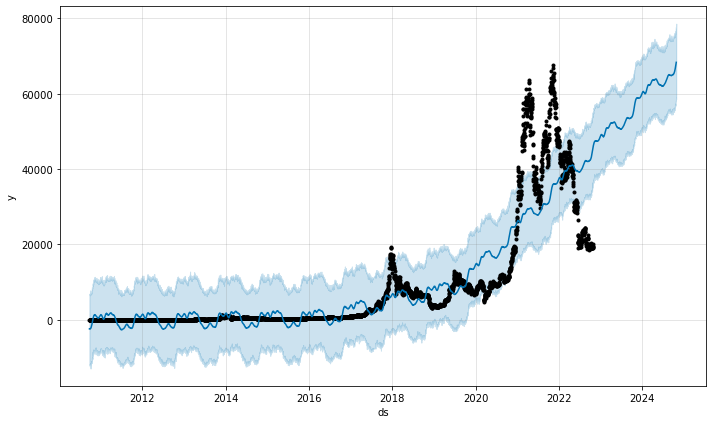

In [48]:
fig1 = m.plot(forecast)
plt.savefig("../Website/images/autocorrelationprices.png", dpi = 72)

In [49]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

00:57:40 - cmdstanpy - INFO - Chain [1] start processing
00:57:41 - cmdstanpy - INFO - Chain [1] done processing
00:57:42 - cmdstanpy - INFO - Chain [1] start processing
00:57:43 - cmdstanpy - INFO - Chain [1] done processing


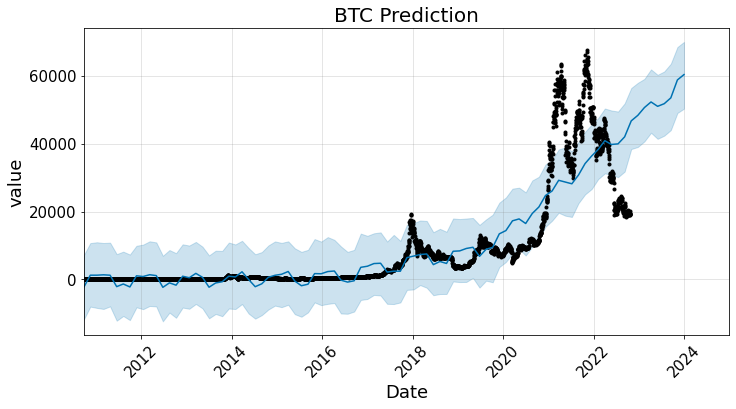

In [50]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("value", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();

In [52]:
import plotly.express as px

fig = px.line(x=df['date'], y=df['price'])
fig.add_scatter(x=prediction['ds'], y=prediction['yhat_lower'], name="Lower")
fig.add_scatter(x=prediction['ds'], y=prediction['yhat_upper'], name="Upper")

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()
fig.write_html('prices.html')

In [ ]:
import plotly.express as px

fig = px.line(x=df['date'], y=df['networkvalue'])


fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

In [ ]:
## Supervised Learning
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [ ]:
df['status'] = df['networkvalue'].apply(lambda x: '1' if x > 0 else '0')


In [ ]:
# Create our features
X = df.drop(columns="status")
X = pd.get_dummies(X)

# Create our target
X = df.drop(columns="date")
y = df['status']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)
   

In [ ]:
## Logistic Regression

In [ ]:
 from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

In [ ]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [ ]:
# print(f'Actual:\t\t{list(y_test[:1000])}')
# print(f'Predicted:\t{list(classifier.predict(X_test[:1000]))}')

In [ ]:
#Random Forest

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
 from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

In [ ]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

In [ ]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

In [ ]:
#Ensemble

In [ ]:
 %matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
 # Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
print(classification_report(y_test, y_pred)) 

In [ ]:
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

In [ ]:
##Bagging

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1, n_estimators=3000).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

In [ ]:
##Extremely Random Trees"

In [ ]:
 from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=1, n_estimators=3000).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators=3000, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

In [ ]:
##Neural Network https://towardsdatascience.com/is-it-possible-to-predict-stock-prices-with-a-neural-network-d750af3de50b